In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn import preprocessing           
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

Get Data

In [3]:
import os 
#Weather
os.chdir("weather_data")
fileList = os.listdir()
weather_data = {}
for i in fileList:
    weather_data[i.split("_")[0]] = pd.read_csv(i)

#Price
os.chdir("price_data")
fileList = os.listdir()
price_data = {}
for i in fileList:
    price_data[i.split("_")[0]] = pd.read_csv(i)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'weather_data'

In [ ]:
price_data["SoybeanFutures"]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,956.50,960.00,949.50,955.00,955.00,2900
1,2018-01-03,956.25,960.50,955.00,959.75,959.75,2582
2,2018-01-04,959.25,960.00,950.25,959.25,959.25,2133
3,2018-01-05,960.00,966.50,960.00,961.50,961.50,1278
4,2018-01-08,960.75,962.25,951.50,958.25,958.25,988
...,...,...,...,...,...,...,...
1254,2022-12-23,1468.75,1484.00,1466.25,1479.00,1479.00,52836
1255,2022-12-27,1490.00,1516.75,1478.25,1482.25,1482.25,61925
1256,2022-12-28,1483.50,1509.75,1482.75,1506.50,1506.50,42705
1257,2022-12-29,1504.75,1516.25,1501.25,1508.75,1508.75,27307


Set Date as Index

In [ ]:
for i in weather_data:
    weather_data[i]['DATE'] = pd.to_datetime(weather_data[i]['DATE'])
    weather_data[i].set_index('DATE', inplace=True)

for i in price_data:
    df = price_data[i]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

Time range of country data are different

In [ ]:
for i in weather_data:
    print(i + " " + str(len(weather_data[i])))

Argentina 1824
Brazil 1824
California 1826
Illinois 1826
Iowa 1826
Minnesota 1826
Nebraska 1826


In [ ]:
for i in weather_data:
    start_date = str(weather_data[i]["DATE"][0])
    end_date = str(weather_data[i]["DATE"].iloc[-1])
    print(f"{i}: start {start_date}    end {end_date}" )

Argentina: start 2018-01-01    end 2022-12-31
Brazil: start 2018-01-01    end 2022-12-31
California: start 2018-01-01    end 2022-12-31
Illinois: start 2018-01-01    end 2022-12-31
Iowa: start 2018-01-01    end 2022-12-31
Minnesota: start 2018-01-01    end 2022-12-31
Nebraska: start 2018-01-01    end 2022-12-31


Weather Data Contains Gaps and last date differs from price data

In [ ]:
for i in weather_data:
    weather_data[i] = weather_data[i]
    weather_data[i] = weather_data[i].asfreq(pd.infer_freq(weather_data[i].index)) #interpolate missing dates
    weather_data[i] = weather_data[i].fillna(method='bfill')
    weather_data[i] = weather_data[i][:-1] #remove last rows in weather data

soybean = df.asfreq(pd.infer_freq(df.index))
df = df.fillna(method='bfill')

In [ ]:
for i in weather_data:
    start_date = str(weather_data[i].index[0])
    end_date = str(weather_data[i].index[-1])
    print(f"{i}: start {start_date}    end {end_date}" )

Argentina: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Brazil: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
California: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Illinois: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Iowa: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Minnesota: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00
Nebraska: start 2018-01-01 00:00:00    end 2022-12-30 00:00:00


Preprocessing

In [ ]:
#Price
soybean_price = price_data["SoybeanFutures"]
soybean_close_price = soybean_price["Close"]

#Features
features = pd.DataFrame()
num_feature = 1 #total number of features, including close price and all weather data
for i in weather_data:
    df = weather_data[i]
    features = pd.concat((features, df), axis=1)
    num_feature += len(weather_data[i].columns)

#features = pd.merge(soybean_price, features, left_index=True, right_index=True, how='inner') #Include close price as a feature


STL Decomposition

In [ ]:
price_stl = STL(soybean_close_price).fit #perform STL decomposition on price
price_comp = [price_stl.trend, price_stl.seasonal, price_stl.resid]  #store components into price list
features_comp = [pd.merge(price_comp[i], features, left_index=True, right_index=True, how='inner') for i in range(3)] # generate features list where each element contains all weather features concatenated with associated component
#features_stl = features.apply(stl_decomp)

Text(0.5, 1.0, 'Residual')

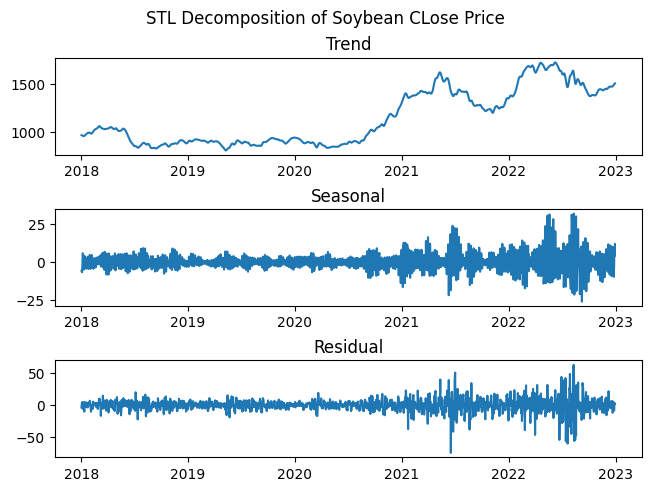

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,layout='constrained')
fig.suptitle('STL Decomposition of Soybean CLose Price')
ax1.plot(price_comp[0])
ax1.set_title('Trend')
ax2.plot(price_comp[1])
ax2.set_title('Seasonal')
ax3.plot(price_comp[2])
ax3.set_title('Residual')

Sample Data

In [ ]:
def sampleData(features, price ,sampleLength):
  x = []
  y = []
  for i in range(len(price)-sampleLength-1):
    x += [features[i:i+sampleLength]]
    y += [price[i+sampleLength]]

  x = np.array(x)
  y = np.array(y)

  y = y[..., np.newaxis]
  
  return x, y

In [ ]:
sampleLength = 30
x = [[],[],[]]
y = [[],[],[]]
for i in range(3):
    x[i], y[i] = sampleData(features_comp[i].to_numpy(), price_comp[i].to_numpy(),30)


Train Test Split

In [ ]:
def train_test_split(x, y, split=0.2):
  trainLen = round(len(x)*(1-split))
  trainX, trainY, testX, testY = x[:trainLen], y[:trainLen], x[trainLen:], y[trainLen:]
  return trainX, trainY, testX, testY

In [ ]:
trainX = [[],[],[]]
trainY = [[],[],[]]
testX = [[],[],[]]
testY = [[],[],[]]
for i in range(3):
    trainX[i], trainY[i], testX[i], testY[i] = train_test_split(x[i], y[i])

Model

In [ ]:
def model():
    return Sequential([
      LSTM(128, input_shape=(sampleLength,num_feature), return_sequences = True),
      Dropout(0.2),
      LSTM(128),
      Dropout(0.2),
      Dense(16, activation="relu"),
      Dense(1, activation="linear")
    ])

In [ ]:
#3 models for: Trend, Seasonal, Residual
trend_model = model()
seasonal_model = model()
residual_model = model()

Compile and Optimizer

In [ ]:
def compile(model, lr=0.0001):
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mse"]
        )

In [ ]:
compile(trend_model)
compile(seasonal_model)
compile(residual_model)

Fitting

In [ ]:
def fit(model,trainX, trainY, testX, testY, epochs = 40, batch_size = 32):
    return model.fit(
            trainX, trainY,
            validation_data = (testX, testY),
            epochs = epochs,
            batch_size = batch_size)

In [ ]:
history_trend = fit(trend_model, trainX[0], trainY[0], testX[0], testY[0])
history_seasonal = fit(seasonal_model, trainX[1], trainY[1], testX[1], testY[1])
history_residual = fit(residual_model, trainX[2], trainY[2], testX[2], testY[2])

Epoch 1/40
45/45 [==============================] - 5s 52ms/step - loss: 1101884.6250 - mse: 1101884.6250 - val_loss: 2337521.2500 - val_mse: 2337521.2500
Epoch 2/40
45/45 [==============================] - 2s 37ms/step - loss: 1045451.0000 - mse: 1045451.0000 - val_loss: 2249059.7500 - val_mse: 2249059.7500
Epoch 3/40
45/45 [==============================] - 2s 38ms/step - loss: 980939.9375 - mse: 980939.8750 - val_loss: 2139990.7500 - val_mse: 2139990.7500
Epoch 4/40
45/45 [==============================] - 2s 37ms/step - loss: 902861.5625 - mse: 902861.5625 - val_loss: 2008407.5000 - val_mse: 2008407.5000
Epoch 5/40
45/45 [==============================] - 2s 37ms/step - loss: 813945.9375 - mse: 813945.9375 - val_loss: 1859792.0000 - val_mse: 1859792.0000
Epoch 6/40
45/45 [==============================] - 2s 37ms/step - loss: 717583.0625 - mse: 717583.0625 - val_loss: 1698328.6250 - val_mse: 1698328.6250
Epoch 7/40
45/45 [==============================] - 2s 39ms/step - loss: 61794

Text(0.5, 1.0, 'Residual')

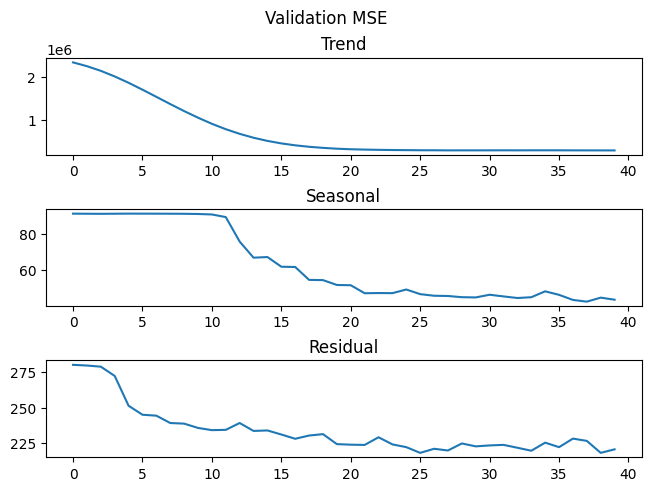

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,layout='constrained')
fig.suptitle('Validation MSE')
ax1.plot(history_trend.history["val_mse"])
ax1.set_title('Trend')
ax2.plot(history_seasonal.history["val_mse"])
ax2.set_title('Seasonal')
ax3.plot(history_residual.history["val_mse"])
ax3.set_title('Residual')

Predict

In [ ]:
def predict(price, features):
    price = pd.DataFrame(price)
    input_stl = stl_decomp(pd.DataFrame(price))
    input_comp = [input_stl.trend, input_stl.seasonal, input_stl.resid]
    features_comp = [pd.merge(input_comp[i], features, left_index=True, right_index=True, how='inner') for i in range(3)]
    pred_trend = trend_model.predict(np.asarray(features_comp[0]))
    pred_seasonal = seasonal_model.predict(np.asarray(features_comp[1]))
    pred_residual = residual_model.predict(np.asarray(features_comp[2]))
    return pred_trend + pred_seasonal + pred_residual

In [ ]:
prediction = []
x, y = sampleData(features.to_numpy(), soybean_close_price.to_numpy() ,sampleLength)
for n, i in enumerate(x):
    print(i.shape)
    prediction += [predict(y[n],x[n])]

(30, 35)


AttributeError: 'numpy.ndarray' object has no attribute 'asfreq'

In [ ]:
x

array([[[ 2.11000000e+01,  3.82000000e+01,  3.00000000e+00, ...,
         -3.32000000e+01,  1.66666667e-03,  4.90454545e+00],
        [ 2.21092308e+01,  3.42000000e+01,  4.80000000e+00, ...,
         -3.12000000e+01,  7.31707317e-04,  6.98181818e+00],
        [ 2.33784615e+01,  3.87000000e+01,  4.00000000e+00, ...,
         -1.69000000e+01,  1.46341463e-03,  1.02363636e+01],
        ...,
        [ 2.31484375e+01,  3.65000000e+01,  2.10000000e+00, ...,
         -1.47000000e+01,  0.00000000e+00,  8.26744186e+00],
        [ 2.37415385e+01,  3.90000000e+01,  4.00000000e+00, ...,
         -1.84000000e+01,  5.26315789e-04,  5.55581395e+00],
        [ 2.42415385e+01,  3.90000000e+01,  5.90000000e+00, ...,
         -1.61000000e+01,  0.00000000e+00,  9.27441860e+00]],

       [[ 2.21092308e+01,  3.42000000e+01,  4.80000000e+00, ...,
         -3.12000000e+01,  7.31707317e-04,  6.98181818e+00],
        [ 2.33784615e+01,  3.87000000e+01,  4.00000000e+00, ...,
         -1.69000000e+01,  1.46341463e

In [ ]:
soybean_close_price.to_numpy()

array([ 955.  ,  959.75,  959.25, ..., 1506.5 , 1508.75, 1519.25])